In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import os


In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', tsname ='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
def plot_ts_and_points(tser, start_point, step):
    new_series = [None for i in range(len(tser))]
    for i in range(len(tser)):
        pos = start_point + step * i
        if pos >= len(tser):
            break
        new_series[pos] = tser[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        tser.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [5]:
os.chdir(r'd:\ml\временные ряды')

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


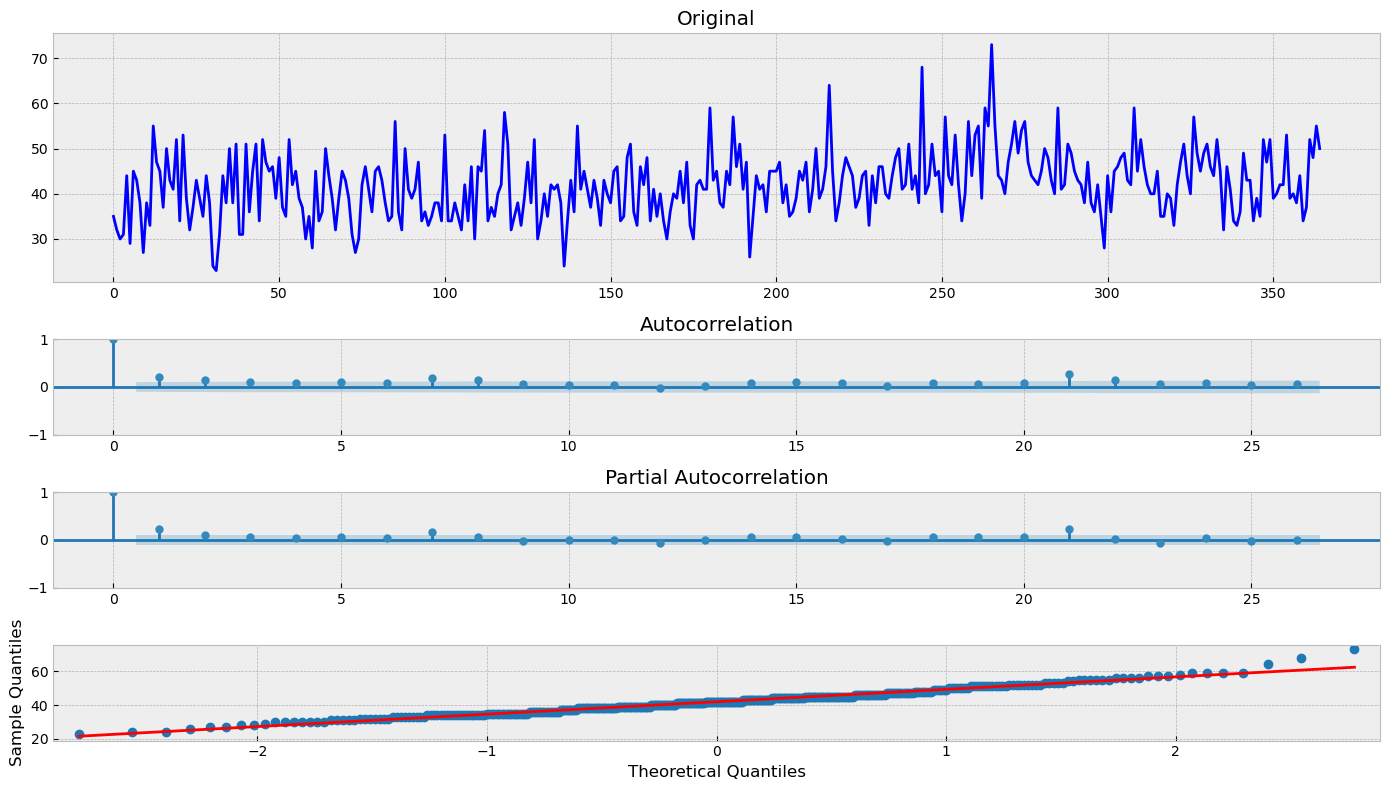

In [6]:
ts = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']
nplt = 'daily-total-female-births'
tsplot(ts,tsname = nplt)

Попробуем подобрать параметры с помощью библиотеки pmdarima

In [7]:

import pmdarima as pm
model = pm.auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2474.497, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3776.976, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2656.891, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3407.164, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2471.358, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2472.653, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2471.853, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2474.287, Time=0.32 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.518 seconds
                               SARIMAX Results                                
Dep. Variable:               

In [8]:
# В итоге парметры модели ARIMA(2,0,1)

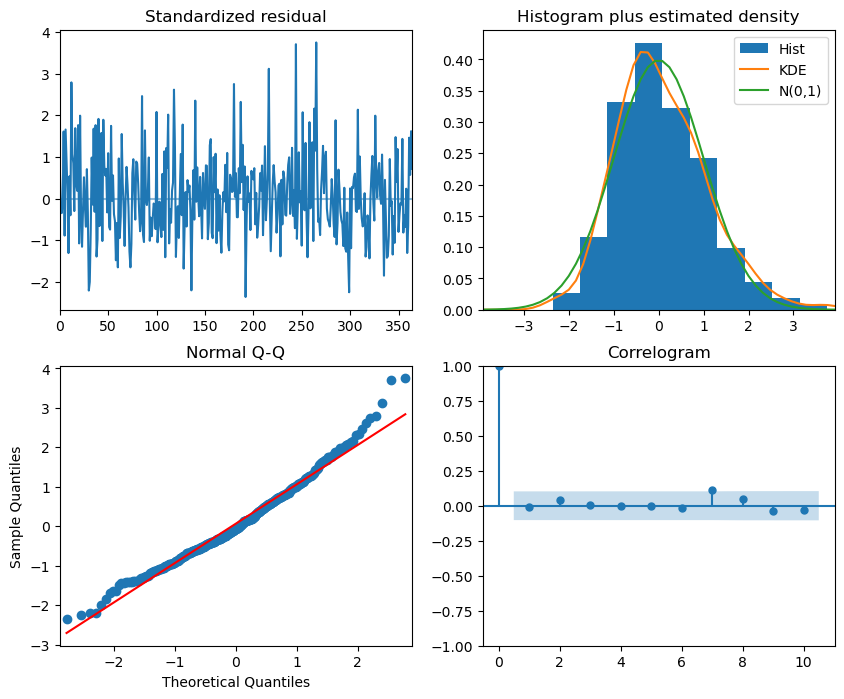

In [9]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

- Остаточные ошибки, по-видимому, колеблются вокруг среднего значения, равного нулю, и имеют равномерную дисперсию с выбросами
- Нормальное распределение, немного сдвинуто вправо
- Теоретические квантили: В основном точки совпадают с красной линией за исключением старта и конца
-  остаточные ошибки не являются автокоррелированными
В целом модель подходит, берем ее для прогнозирования

In [10]:
from arch import arch_model

In [11]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 2
o_ = 0
q_ = 1

am = arch_model(ts, p=p_, o=o_, q=q_, dist='normal')
res = am.fit(update_freq=5, disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1244.57
Distribution:                  Normal   AIC:                           2499.13
Method:            Maximum Likelihood   BIC:                           2518.63
                                        No. Observations:                  365
Date:                Sun, Mar 10 2024   Df Residuals:                      364
Time:                        20:49:39   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41.9514      0.636     65.937      0.000 [ 40.704, 43.198]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.3422     11.104      0.301      0.763    [-18.422, 25.107]
alpha[1]       0.0106  5.567e-02      0.190      0.849 [-9.854e-02,  0.120]
alpha[2]   1.4226e-12      0.119  1.194e-11      1.000    [ -0.234,  0.234]
beta[1]        0.9259      0.274      3.385  7.112e-04    [  0.390,  1.462]
===========================================================================

Covariance estimator: robust
"""

In [12]:
forecast = res.forecast(horizon=5)

In [13]:
forecast.mean

,h.1,h.2,h.3,h.4,h.5
364,41.951402,41.951402,41.951402,41.951402,41.951402
